In [12]:
from torchvision import models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import time
#from google.colab import files
#uncomment the above line tov use colab's files.upload function
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2025-06-16 04:52:17 URL:https://www.shutterstock.com/image-photo/orange-suv-on-street-downtown-600nw-2557666931.jpg [63659/63659] -> "bird.png" [1]


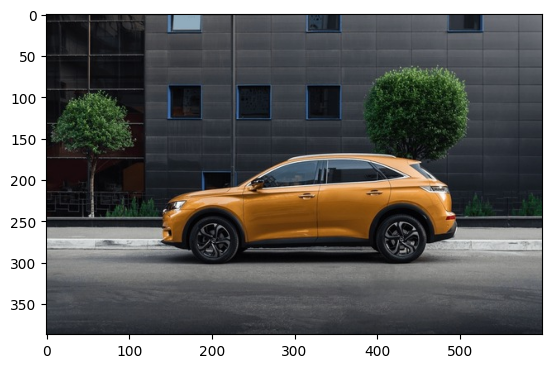

In [13]:
!wget -nv https://www.shutterstock.com/image-photo/orange-suv-on-street-downtown-600nw-2557666931.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

In [14]:
def decode_segmap(image, nc=21):


  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [15]:
def crop(image, source, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l

    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[1, 1]
    b[idx] = label_colors[1, 2]

  rgb = np.stack([r, g, b], axis=2)
  foreground = cv2.imread(source)

  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground, (r.shape[1], r.shape[0]))

  background = 255 * np.ones_like(rgb).astype(np.uint8)

  foreground  = foreground.astype(float)
  background = background.astype(float)

  th, alpha = cv2.threshold(np.array(rgb), 0, 255, cv2.THRESH_BINARY)
  alpha = cv2.GaussianBlur(alpha, (7, 7), 0)
  alpha = alpha.astype(float) / 255

  foreground = cv2.multiply(alpha, foreground)

  background = cv2.multiply(1.0 - alpha, background)

  outImage = cv2.add(foreground, background)

  return outImage / 255

In [16]:
def modify():

  plt.imshow(img); plt.axis('off'); plt.show()
  trf = T.Compose([T.Resize(640),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])

  inp = trf(img).unsqueeze(0)
  out = dlab(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  result = decode_segmap(om)
  plt.imshow(result); plt.axis('off'); plt.show()

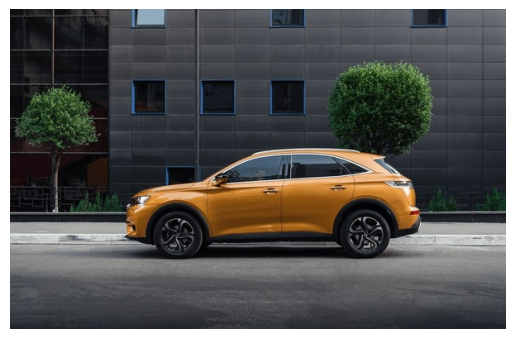

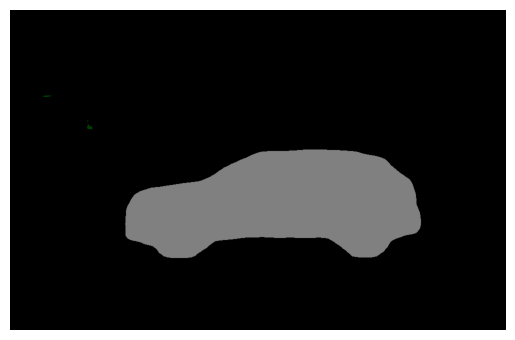

In [17]:
modify()